## 分析电子商务网站运行的 A/B 测试
## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

这个项目，你将要了解的是电子商务网站运行的 A/B 测试的结果。该公司开发了一个新的网页，以试图增加“转换”的用户数量，这意味着决定支付公司产品的用户数量。你的目标是帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

<a id='probability'></a>
## I - 概率

先导入项目所需库，然后开始任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# 设置随机数生成器的种子，以确保在测验中获得与我们设置的答案相同的答案
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。 

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('../input/ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查找数据集中的行数。

In [3]:
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [4]:
df['user_id'].unique()
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [5]:
print(df['converted'].unique())
df['converted'].mean()

[0 1]


0.11965919355605512

[](http://)e.  `new_page` 与 `treatment` 不一致的次数。

- 方法1

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [7]:
print(df.group.value_counts())
df.landing_page.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64


old_page    147239
new_page    147239
Name: landing_page, dtype: int64

- 方法2

In [8]:
mis_match1 = df[(df['landing_page'] == "new_page") & (df['group'] == "control")].count()[0]
mis_match1

1928

In [9]:
mis_match2 = df[(df['landing_page'] == "old_page") & (df['group'] == "treatment")].count()[0]
mis_match2

1965

In [10]:
mis_match1 + mis_match2

3893


f. 是否有任何行存在缺失值？

In [11]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

##### **数据汇总**
- 数据集行数：**294478**
- 数据集的用户数量（不同 `user_id` 数）：**290584**
- 转化用户占比：**12%**
- `new_page` 和 `treatment` 不匹配的次数：**3893**
- 是否有任何行空缺数值：**否**

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？ 

a. 现在，创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [12]:
df2 = df[(df['landing_page'] == "new_page") & (df['group'] == 'treatment') | (df['landing_page'] == "old_page") & (df['group'] == 'control')]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


如果某些行 `landing_page` 列和 `group` 列不配，该如何处理？（即， `treatment` 不是匹配 `new_page` 的行或 `control` 不是匹配 `old_page` 的行）
- 删除这些行，不使用混乱数据

In [14]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [15]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` 使用 **df2** 进行评估。

a.  **df2** 中有多少唯一的 **user_id**?

In [16]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [17]:
duplicated_user_id = df2[df2.duplicated('user_id', keep= False)]
duplicated_user_id

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. 这个重复的  **user_id** 的行信息是什么？

In [18]:
duplicated_user_id.index

Int64Index([1899, 2893], dtype='int64')

d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [19]:
df2 = df2.drop_duplicates('user_id', keep='first')
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted


更新后数据集汇总
- df2的用户数量（不同 `user_id`）：**290584**
- df2中有一个重复的 `user_id` ，是什么？ **773192**
- 这个重复的 `user_id` 对应的 `landing_page` 信息是什么？ **new_page**
- 这个重复的 `user_id` 对应的 `group` 信息是什么？ **treatment**
- 这个重复的 `user_id` 对应的 `converted` 数值是什么？ **0**

`4.` 在下面的单元格中，使用 **df2** 探索。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [20]:
df2.converted.mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [21]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [22]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [23]:
num_new_page = df2.query('landing_page == "new_page"').user_id.count()
num_users = df2.user_id.count()
num_new_page / num_users

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？

- 根据数据可以看出，没有任何证据表明新页面会带来更多转化率。

- 用户转化的总概率：**0.1196**
- Control 组的用户转化率：**0.1204**
- Treatment 组的用户转化率：**0.188**
- 用户收到**new page**的概率：**0.5001**

<a id='ab_test'></a>
## II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

- $H_0: P_{new} - P_{old} \leq 0$

- $H_1: P_{new} - P_{old} > 0$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？

In [24]:
P_new = df2['converted'].mean()
P_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [25]:
P_old = P_new
P_old 

0.11959708724499628

c.  $n_{new}$ 是多少？

In [26]:
n_new = df2[df2['landing_page'] == 'new_page'].count()[0]
n_new

145310

d.  $n_{old}$?是多少？

In [27]:
n_old = df2[df2['landing_page'] == 'old_page'].count()[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(帮助  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [28]:
new_page_converted = np.random.choice([0, 1], size=n_new, p= [(1-P_new), P_new])
new_page_converted

array([0, 1, 0, ..., 0, 1, 0])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [29]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-P_old), P_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [30]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.0003420652016033199

h. 使用**a. 到 g.** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [31]:
p_diffs = []

for i in range(10000):
    p_new_converted = np.random.choice([0, 1], size=n_new, p=[(1-P_new), P_new])
    p_old_converted = np.random.choice([0, 1], size=n_old, p=[(1-P_old), P_old])
    p_diff = p_new_converted.mean() - p_old_converted.mean()
    p_diffs.append(p_diff)

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？

(array([1.000e+00, 1.400e+01, 1.280e+02, 7.000e+02, 2.070e+03, 3.141e+03,
        2.568e+03, 1.099e+03, 2.460e+02, 3.300e+01]),
 array([-0.00563903, -0.00464448, -0.00364994, -0.0026554 , -0.00166086,
        -0.00066632,  0.00032823,  0.00132277,  0.00231731,  0.00331185,
         0.0043064 ]),
 <a list of 10 Patch objects>)

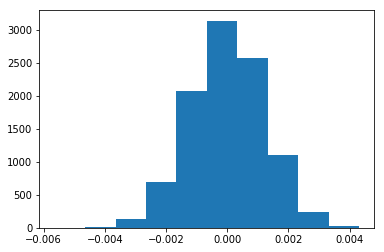

In [32]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

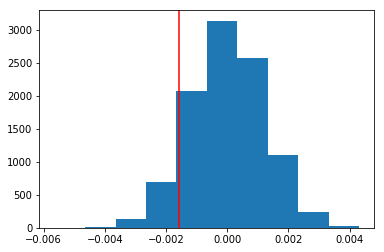

In [33]:
plt.hist(p_diffs)
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
plt.axvline(obs_diff, color='red')

In [34]:
(p_diffs > obs_diff).mean()

0.9053

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？


- p 值的定义是 如果零假设为真，观察到统计量 (或支持备择假设的更多极端) 的概率。
- p值较大表示不应该抛弃零假设，在这个案例中这表明我们应该认为新旧页面效果差不多

通过对比 p 值和错误阈值 ($\alpha$)，我们可以决定选择哪个假设。

- 一般$\alpha$取值为0.05

- $p$  $\leq$ $\alpha$ $\Rightarrow$ 拒绝 $H_0$
- $p$  $>$ $\alpha$ $\Rightarrow$ 不能拒绝 $H_0$ 
![](https://raw.githubusercontent.com/hufe09/GitNote-Images/master/Picee/image.cao27mny5o.png)

- $p_{val} = 0.9052$
- 从得到的P值可以看出，控制组和试验组点击率的差异不明显，新旧页面效果差不多
- 根据 $p_{val}$ 无法拒绝零假设

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [35]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control']['converted'].sum()
convert_new = df2[df2['group'] == 'treatment']['converted'].sum()
n_old = df2[df2['group'] == 'control'].count()[0]
n_new = df2[df2['group'] == 'treatment'].count()[0]

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [36]:
z_score, p_val = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_val

(1.3109241984234394, 0.9050583127590245)

In [37]:
from scipy.stats import norm
norm.cdf(z_score), norm.ppf(1-(0.05))

(0.9050583127590245, 1.6448536269514722)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

- **z-score 1.3109241984234394 < 1.6448536269514722**, 在95%的置信区间上
- 不能拒绝零假设，所以旧页面转化率至少和新页面一样好
- j和k结果一致

- 零假设下的 **p_new** 是多少？ **0.1196**
- 零假设下的 **p_old** 是多少？ **0.1196**
- **n_new** 是多少？ **145310**
- **n_old** 是多少？** 145274**
- 零假设下 **p_new** 与 **p_old** 的差异值是多少？（**p_new - p_old**） : **0**

<a id='regression'></a>
## III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？


- 逻辑回归

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [38]:
# 创建虚拟列
df2[['control', 'treatment']]= pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [39]:
# 逻辑回归
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]) # logit模型拟合
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 模型摘要

In [40]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        13:25:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

- $p_{val} = 0.190$ 
- **逻辑回归** 部分的零假设为 **ab_page = 0**，备择假设为 **ab_page != 0**

- 与**A/B 测试** 部分零假设和备择假设不同，导致$p_{val}$不同

f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

- 单一元素对预测人的行为是困难的，将其他因素添加到回归模型中可以更准确的预测人的行为。
- 弊端是这些因素可能并不是相互独立的，可能相互之间会产生影响。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 **effect** 项。导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？
为这些国家的列创建虚拟变量（将需要为这三个虚拟变量增加两列）。

In [41]:
# 读取国家数据
df_countries = pd.read_csv('../input/countries.csv')
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [42]:
# 按user_id合并表
df3 = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,control,treatment,ab_page,intercept
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,1


In [43]:
# 创建虚拟列
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3 = df3.drop(['CA'], axis=1)
df3.head()

,country,timestamp,group,landing_page,converted,control,treatment,ab_page,intercept,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,1,1,0


In [44]:
# 逻辑回归
df3['intercept'] = 1
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'US', 'UK']])
results = logit_mod.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 26 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        13:25:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.

- US和UK的$p_{val} > 0.05$, 说明国家差异对转化率影响不显著。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [45]:
# 添加 UK_ab_page 列
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,control,treatment,ab_page,intercept,UK,US,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,1,1,0,1


In [46]:
# 逻辑回归
df3['intercept'] = 1
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'UK_ab_page']])
results = logit_mod.fit()   # logit模型拟合
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Jul 2019   Pseudo R-squ.:               3.125e-05
Time:                        13:26:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1557
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0257      0.027    -75.518      0.000      -2.078      -1.973
ab_page       -0.0236      0.

- **UK_ab_page** $p_{val}=0.192$
- $p_{val} > 0.05$
- 说明国家-页面的差异对转化率的影响不显著

## 结论
- **不应该运行新页面**

## 参考

- [proportions_ztest](http://knowledgetack.com/python/statsmodels/proportions_ztest/)
- [pandas.DataFrame.join](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html)
- [数据分析运营---A/B测试中20个必须知道的问题](https://blog.csdn.net/zzq900503/article/details/70991497)
- [详解A/B测试的那些坑](https://www.niaogebiji.com/article-17605-1.html)
- [在Airbnb做A/B测试](https://www.jianshu.com/p/c6df75dbb2fa)
- [逻辑回归](https://www.cnblogs.com/Belter/p/6128644.html)
- [线性回归和逻辑回归的理解](https://blog.csdn.net/chenoo0539/article/details/42244241)